In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
from njit_funcs_recursive_grid import *
from backtest import backtest
from plotting import plot_fills
from downloader import Downloader, load_hlc_cache
from pure_funcs import (
    denumpyize,
    numpyize,
    candidate_to_live_config,
    calc_spans,
    analyze_fills,
    create_xk,
    round_dynamic,
    round_values,
    sort_dict_keys,
)
from procedures import (
    dump_live_config,
    load_live_config,
    add_argparse_args,
    prepare_backtest_config,
    make_get_filepath,
)
from time import time
import sys
import argparse
import pprint
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np

In [70]:
plt.rcParams["figure.figsize"] = [24, 13.5]
plt.rcParams["figure.facecolor"] = "w"
pd.set_option("display.precision", 10)

In [99]:
class Args:
    def __init__(self):
        self.backtest_config_path = "configs/backtest/default.hjson"
        self.exchange = "binance"
        self.symbol = "1000SHIBUSDT"
        self.market_type = "futures"
        self.user = "binance_01"
        self.start_date = "2021-07-01"
        self.end_date = "2022-04-14"
        self.starting_balance = 10000.0
        self.starting_configs = ""
        self.base_dir = "backtests"
        self.ohlcv = False  # set to False to use 1s candles


config = await prepare_backtest_config(Args())
dl = Downloader(config)
sts = time()
if config["ohlcv"]:
    data = load_hlc_cache(
        config["symbol"],
        config["start_date"],
        config["end_date"],
        base_dir=config["base_dir"],
        spot=config["spot"],
        exchange=config["exchange"],
    )
    prices = data[:, 3]
    highs = data[:, 1]
    lows = data[:, 2]
    closes = data[:, 3]
else:
    downloader = Downloader(config)
    data = await downloader.get_sampled_ticks()
    prices = data[:, 2]
    highs = data[:, 2]
    lows = data[:, 2]
    closes = data[:, 2]
timestamps = data[:, 0]
config["n_days"] = (timestamps[-1] - timestamps[0]) / (1000 * 60 * 60 * 24)

print(f"millis to load {len(prices)} ticks {(time() - sts) * 1000:.0f}ms")

fetching market_specific_settings...
linear perpetual
linear perpetual
2022-04-15T07:20:08  Validating file 225354877_225399999_1640995203669_1641011662893.csv 2022-01-01T07:00:03.669000 
2022-04-15T07:20:08  Filling gaps from id 225300000 to id 225354876 


C:\AgodaGit\passivbot\downloader.py:121: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gaps = gaps.append(


2022-04-15T07:20:08  fetched ticks 1000SHIBUSDT 225300000 2022-01-01T03:07:32.409000 
2022-04-15T07:20:09  fetched ticks 1000SHIBUSDT 225300999 2022-01-01T03:09:39.052000 
2022-04-15T07:20:10  fetched ticks 1000SHIBUSDT 225301998 2022-01-01T03:12:39.922000 
2022-04-15T07:20:11  fetched ticks 1000SHIBUSDT 225302997 2022-01-01T03:16:09.552000 
2022-04-15T07:20:12  fetched ticks 1000SHIBUSDT 225303996 2022-01-01T03:18:01.206000 
2022-04-15T07:20:12  fetched ticks 1000SHIBUSDT 225304995 2022-01-01T03:19:33.896000 
2022-04-15T07:20:13  fetched ticks 1000SHIBUSDT 225305994 2022-01-01T03:22:51.658000 
2022-04-15T07:20:14  fetched ticks 1000SHIBUSDT 225306993 2022-01-01T03:26:37.164000 
2022-04-15T07:20:15  fetched ticks 1000SHIBUSDT 225307992 2022-01-01T03:29:34.876000 
2022-04-15T07:20:15  fetched ticks 1000SHIBUSDT 225308991 2022-01-01T03:32:30.254000 
2022-04-15T07:20:16  fetched ticks 1000SHIBUSDT 225309990 2022-01-01T03:35:31.194000 
2022-04-15T07:20:17  fetched ticks 1000SHIBUSDT 225310

100%|█████████████████████████████████████████████████████████████████████████████| 49.1M/49.1M [00:05<00:00, 8.76MB/s]


2022-04-15T07:23:18  Saving file 35488350_35499999_1625097601572_1625103068223.csv 2021-07-01T07:00:01.572000 
2022-04-15T07:23:18  Saving file 35500000_35599999_1625103068278_1625138141820.csv 2021-07-01T08:31:08.278000 
2022-04-15T07:23:19  Saving file 35600000_35699999_1625138141922_1625196752384.csv 2021-07-01T18:15:41.922000 
2022-04-15T07:23:19  Saving file 35700000_35799999_1625196752750_1625262909212.csv 2021-07-02T10:32:32.750000 
2022-04-15T07:23:19  Saving file 35800000_35899999_1625262910683_1625327258257.csv 2021-07-03T04:55:10.683000 
2022-04-15T07:23:20  Saving file 35900000_35999999_1625327258257_1625400286146.csv 2021-07-03T22:47:38.257000 
2022-04-15T07:23:20  Saving file 36000000_36099999_1625400289249_1625485274708.csv 2021-07-04T19:04:49.249000 
2022-04-15T07:23:21  Saving file 36100000_36199999_1625485275058_1625546239629.csv 2021-07-05T18:41:15.058000 
2022-04-15T07:23:21  Saving file 36200000_36299999_1625546239629_1625566242853.csv 2021-07-06T11:37:19.629000 
2

100%|█████████████████████████████████████████████████████████████████████████████| 78.8M/78.8M [00:08<00:00, 9.41MB/s]


2022-04-15T07:23:47  Saving file 38900000_38999999_1627766877034_1627853561303.csv 2021-08-01T04:27:57.034000 
2022-04-15T07:23:47  Saving file 39000000_39099999_1627853561407_1627991368469.csv 2021-08-02T04:32:41.407000 
2022-04-15T07:23:48  Saving file 39100000_39199999_1627991368470_1628131288384.csv 2021-08-03T18:49:28.470000 
2022-04-15T07:23:48  Saving file 39200000_39299999_1628131288543_1628264591534.csv 2021-08-05T09:41:28.543000 
2022-04-15T07:23:48  Saving file 39300000_39399999_1628264591942_1628327544854.csv 2021-08-06T22:43:11.942000 
2022-04-15T07:23:49  Saving file 39400000_39499999_1628327545535_1628342703625.csv 2021-08-07T16:12:25.535000 
2022-04-15T07:23:49  Saving file 39500000_39599999_1628342703640_1628368635302.csv 2021-08-07T20:25:03.640000 
2022-04-15T07:23:50  Saving file 39600000_39699999_1628368635326_1628382417782.csv 2021-08-08T03:37:15.326000 
2022-04-15T07:23:50  Saving file 39700000_39799999_1628382417791_1628385441619.csv 2021-08-08T07:26:57.791000 
2

100%|█████████████████████████████████████████████████████████████████████████████| 91.8M/91.8M [00:08<00:00, 11.2MB/s]


2022-04-15T07:24:25  Saving file 44400000_44499999_1630435203706_1630536258794.csv 2021-09-01T01:40:03.706000 
2022-04-15T07:24:26  Saving file 44500000_44599999_1630536261766_1630621022446.csv 2021-09-02T05:44:21.766000 
2022-04-15T07:24:26  Saving file 44600000_44699999_1630621023106_1630718517640.csv 2021-09-03T05:17:03.106000 
2022-04-15T07:24:27  Saving file 44700000_44799999_1630718518692_1630773666388.csv 2021-09-04T08:21:58.692000 
2022-04-15T07:24:27  Saving file 44800000_44899999_1630773666524_1630808079297.csv 2021-09-04T23:41:06.524000 
2022-04-15T07:24:28  Saving file 44900000_44999999_1630808079484_1630875967419.csv 2021-09-05T09:14:39.484000 
2022-04-15T07:24:28  Saving file 45000000_45099999_1630875968652_1630938707693.csv 2021-09-06T04:06:08.652000 
2022-04-15T07:24:28  Saving file 45100000_45199999_1630938707776_1631008470214.csv 2021-09-06T21:31:47.776000 
2022-04-15T07:24:29  Saving file 45200000_45299999_1631008470214_1631026582125.csv 2021-09-07T16:54:30.214000 
2

100%|█████████████████████████████████████████████████████████████████████████████| 1.20G/1.20G [01:55<00:00, 11.2MB/s]


2022-04-15T07:30:19  Saving file 50900000_50999999_1633021550532_1633093112867.csv 2021-10-01T00:05:50.532000 
2022-04-15T07:30:25  Saving file 51000000_51099999_1633093112969_1633176687281.csv 2021-10-01T19:58:32.969000 
2022-04-15T07:30:31  Saving file 51100000_51199999_1633176687281_1633223098020.csv 2021-10-02T19:11:27.281000 
2022-04-15T07:30:37  Saving file 51200000_51299999_1633223098110_1633278180963.csv 2021-10-03T08:04:58.110000 
2022-04-15T07:30:43  Saving file 51300000_51399999_1633278180965_1633285090583.csv 2021-10-03T23:23:00.965000 
2022-04-15T07:30:49  Saving file 51400000_51499999_1633285090899_1633308467391.csv 2021-10-04T01:18:10.899000 
2022-04-15T07:30:55  Saving file 51500000_51599999_1633308467457_1633336305137.csv 2021-10-04T07:47:47.457000 
2022-04-15T07:31:01  Saving file 51600000_51699999_1633336305807_1633349831839.csv 2021-10-04T15:31:45.807000 
2022-04-15T07:31:06  Saving file 51700000_51799999_1633349831914_1633352781156.csv 2021-10-04T19:17:11.914000 
2

100%|███████████████████████████████████████████████████████████████████████████████| 722M/722M [01:08<00:00, 11.0MB/s]


2022-04-15T08:24:11  Saving file 145200000_145299999_1635721735717_1635726754648.csv 2021-11-01T06:08:55.717000 
2022-04-15T08:24:14  Saving file 145300000_145399999_1635726754648_1635730866996.csv 2021-11-01T07:32:34.648000 
2022-04-15T08:24:18  Saving file 145400000_145499999_1635730867014_1635732078980.csv 2021-11-01T08:41:07.014000 
2022-04-15T08:24:22  Saving file 145500000_145599999_1635732079000_1635733409541.csv 2021-11-01T09:01:19 
2022-04-15T08:24:26  Saving file 145600000_145699999_1635733409541_1635734764941.csv 2021-11-01T09:23:29.541000 
2022-04-15T08:24:29  Saving file 145700000_145799999_1635734764941_1635735955730.csv 2021-11-01T09:46:04.941000 
2022-04-15T08:24:33  Saving file 145800000_145899999_1635735955730_1635738422665.csv 2021-11-01T10:05:55.730000 
2022-04-15T08:24:37  Saving file 145900000_145999999_1635738422665_1635740887118.csv 2021-11-01T10:47:02.665000 
2022-04-15T08:24:40  Saving file 146000000_146099999_1635740887194_1635744539541.csv 2021-11-01T11:28:0

100%|███████████████████████████████████████████████████████████████████████████████| 334M/334M [00:31<00:00, 11.0MB/s]


2022-04-15T08:45:14  Saving file 200300000_200399999_1638316070579_1638319248306.csv 2021-12-01T06:47:50.579000 
2022-04-15T08:45:16  Saving file 200400000_200499999_1638319248306_1638324095089.csv 2021-12-01T07:40:48.306000 
2022-04-15T08:45:18  Saving file 200500000_200599999_1638324095273_1638329552532.csv 2021-12-01T09:01:35.273000 
2022-04-15T08:45:19  Saving file 200600000_200699999_1638329552677_1638333201227.csv 2021-12-01T10:32:32.677000 
2022-04-15T08:45:21  Saving file 200700000_200799999_1638333201312_1638337496651.csv 2021-12-01T11:33:21.312000 
2022-04-15T08:45:23  Saving file 200800000_200899999_1638337496651_1638341123345.csv 2021-12-01T12:44:56.651000 
2022-04-15T08:45:24  Saving file 200900000_200999999_1638341123371_1638346508982.csv 2021-12-01T13:45:23.371000 
2022-04-15T08:45:26  Saving file 201000000_201099999_1638346508983_1638349624998.csv 2021-12-01T15:15:08.983000 
2022-04-15T08:45:28  Saving file 201100000_201199999_1638349624998_1638354879329.csv 2021-12-01T

<AxesSubplot:title={'center':'Coin Price'}, xlabel='Time', ylabel='Price'>

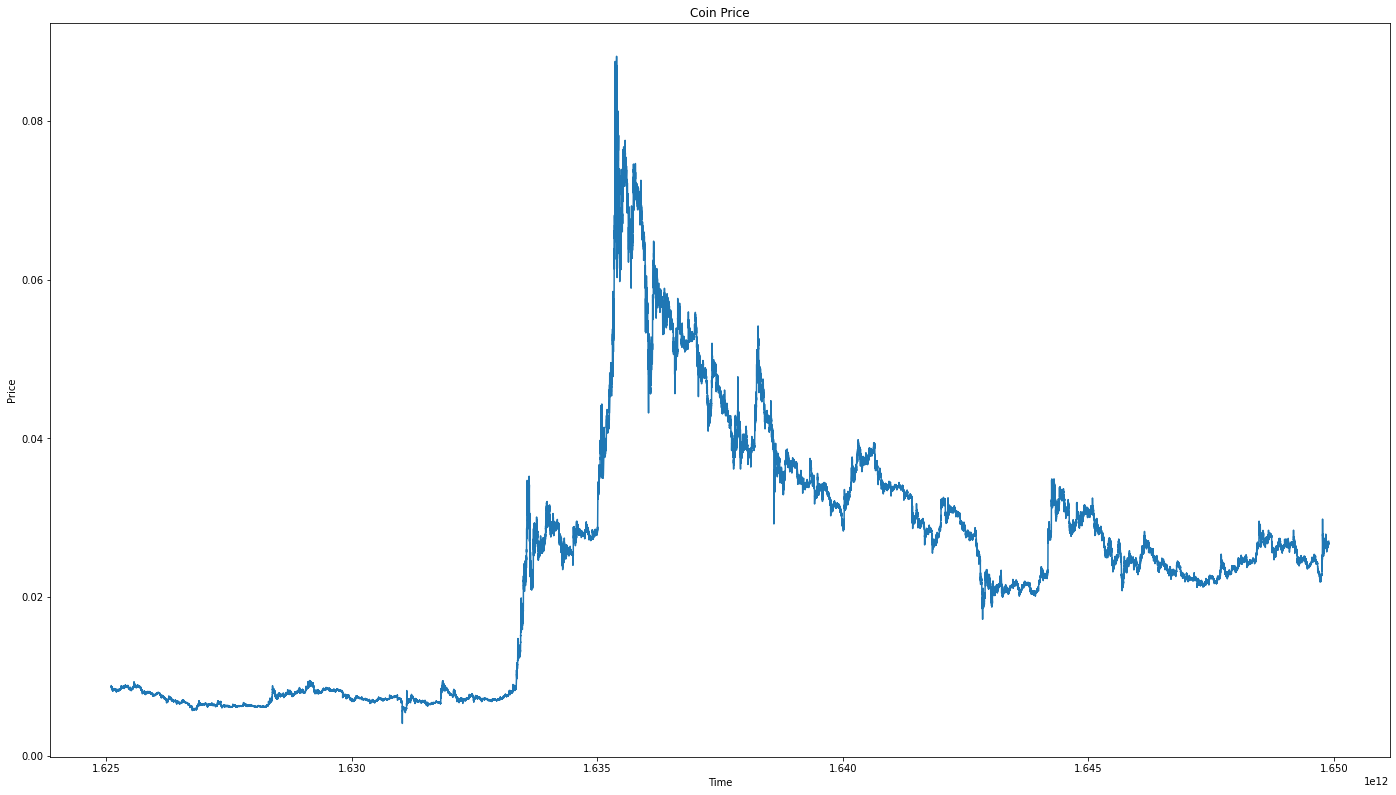

In [100]:
df = pd.DataFrame({"timestamp": timestamps, "price": prices}).set_index("timestamp")
df.price.iloc[::100].plot(title="Coin Price", xlabel="Time", ylabel="Price")

In [73]:
# choose a slice on which to test
wsize_days = 60
ts = int(data[-1][0] - 60 * 60 * 24 * 1000 * wsize_days)
idx = np.argmax(data[:, 0] >= ts)
dataslice = data[idx:]
len(dataslice)

5184001

In [101]:
hand_tuned = {"config_name": "recursive_grid_1000SHIBUSDT_243days",
 "logging_level": 0,
 "long": {"auto_unstuck_ema_dist": 0.07537071056829926,
          "auto_unstuck_wallet_exposure_threshold": 0.19669988220778298,
          "ddown_factor": 2.977350776264995,
          "ema_span_0": 1590.7673738930807,
          "ema_span_1": 2555.569985614937,
          "enabled": True,
          "initial_eprice_ema_dist": -0.036633754044480854,
          "initial_qty_pct": 0.05183901530921238,
          "markup_range": 0.058494042849077325,
          "min_markup": 0.058764069903290785,
          "n_close_orders": 4,
          "rentry_pprice_dist": 0.03271893972031065,
          "rentry_pprice_dist_wallet_exposure_weighting": 69.40466141303567,
          "wallet_exposure_limit": 0.1632046549148019},
 "short": {"auto_unstuck_ema_dist": 0.09972790931046338,
           "auto_unstuck_wallet_exposure_threshold": 0.06559262162518376,
           "ddown_factor": 2.304489996146624,
           "ema_span_0": 1055.6577441874203,
           "ema_span_1": 2888.7744234017828,
           "enabled": True,
           "initial_eprice_ema_dist": -0.02998678962458838,
           "initial_qty_pct": 0.07702488418844138,
           "markup_range": 0.022206983627948464,
           "min_markup": 0.014231970991650302,
           "n_close_orders": 9,
           "rentry_pprice_dist": 0.01553099174200374,
           "rentry_pprice_dist_wallet_exposure_weighting": 22.60722411105582,
           "wallet_exposure_limit": 0.1517033532129698}}

config_to_test = {**config, **hand_tuned}


Grid Span Long = 75.59%


,qty,price,type,psize,pprice,wallet_exposure,eprice_pprice_diff,ddown_factor,bkr_price
0,3141.0,0.026936,long_ientry_normal,3141.0,0.0269360000,0.0084605976,0.0000000000,NaN,0.0
1,9352.0,0.025078,long_rentry,12493.0,0.0255451398,0.0319135432,0.0186274758,2.9773957338,0.0
2,37196.0,0.019961,long_rentry,49689.0,0.0213649860,0.1061604788,0.0703364547,2.9773473145,0.0
3,86746.0,0.006576,long_rentry,136435.0,0.0119620807,0.1632046484,0.8190512055,1.7457787438,0.0


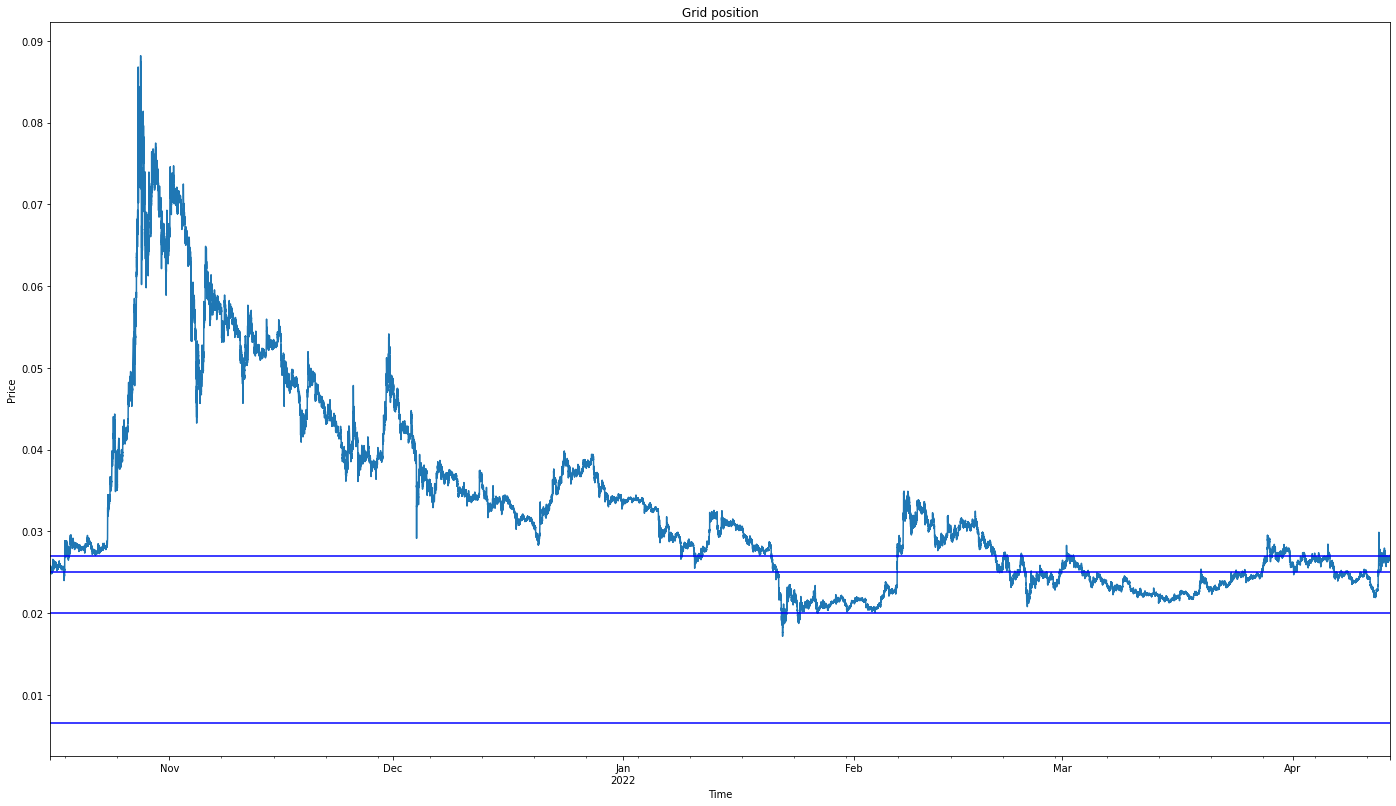

In [104]:
config_to_test['long'] = {"auto_unstuck_ema_dist": 0.07537071056829926,
          "auto_unstuck_wallet_exposure_threshold": 0.19669988220778298,
          "ddown_factor": 2.977350776264995,
          "ema_span_0": 1590.7673738930807,
          "ema_span_1": 2555.569985614937,
          "enabled": True,
          "initial_eprice_ema_dist": -0.036633754044480854,
          "initial_qty_pct": 0.05183901530921238,
          "markup_range": 0.058494042849077325,
          "min_markup": 0.058764069903290785,
          "n_close_orders": 4,
          "rentry_pprice_dist": 0.015,
          "rentry_pprice_dist_wallet_exposure_weighting": 69.40466141303567,
          "wallet_exposure_limit": 0.1632046549148019}
grid_long = calc_recursive_entries_long(
    Args().starting_balance,
    0.0,
    0.0,
    df.price.iloc[-1],
    df.price.iloc[-1],
    config_to_test["inverse"],
    config_to_test["qty_step"],
    config_to_test["price_step"],
    config_to_test["min_qty"],
    config_to_test["min_cost"],
    config_to_test["c_mult"],
    config_to_test["long"]["initial_qty_pct"],
    config_to_test["long"]["initial_eprice_ema_dist"],
    config_to_test["long"]["ddown_factor"],
    config_to_test["long"]["rentry_pprice_dist"],
    config_to_test["long"]["rentry_pprice_dist_wallet_exposure_weighting"],
    config_to_test["long"]["wallet_exposure_limit"],
    config_to_test["long"]["auto_unstuck_ema_dist"],
    config_to_test["long"]["auto_unstuck_wallet_exposure_threshold"],
    whole_grid=True,
)

gdf_long = pd.DataFrame(
    grid_long, columns=["qty", "price", "type", "psize", "pprice", "wallet_exposure"]
)
gdf_long.loc[:, "eprice_pprice_diff"] = abs(gdf_long.price - gdf_long.pprice) / gdf_long.price
gdf_long.loc[:, "ddown_factor"] = gdf_long.qty / gdf_long.psize.shift()
gdf_long.loc[:, "bkr_price"] = gdf_long.apply(
    lambda x: calc_bankruptcy_price(
        Args().starting_balance,
        x.psize,
        x.pprice,
        0.0,
        0.0,
        config_to_test["inverse"],
        config_to_test["c_mult"],
    ),
    axis=1,
)

# Display grid on graph
n_ticks = 60 * 60 * 24 * 180  # 14 days
dfx = pd.DataFrame(
    {
        "timestamp": pd.to_datetime(timestamps[-n_ticks:], unit="ms"),
        "price": prices[-n_ticks:],
    }
).set_index("timestamp")
lastdayfrom = pd.to_datetime(Args().end_date)
# lastdayfrom = pd.Timestamp('2021-05-21')
fig = (
    dfx.price.loc[lastdayfrom - pd.Timedelta(days=180) : lastdayfrom]
    .iloc[::100]
    .plot(title="Grid position", xlabel="Time", ylabel="Price")
)
for i, e in enumerate(gdf_long.itertuples()):
    fig.axhline(y=e.price, color="b", linestyle="-")

print(f"\nGrid Span Long = {-(gdf_long.price.iloc[-1] / gdf_long.price.iloc[0] - 1) * 100:.2f}%")

pd.concat([gdf_long]).sort_values("price", ascending=False)

Grid Span Short = 23.20%


,qty,price,type,psize,pprice,wallet_exposure,eprice_pprice_diff,ddown_factor,bkr_price
2,-33035.0,0.033184,short_rentry,-47370.0,0.0316828259,0.1500815462,0.0452378893,2.3044994768,0.2427869002
1,-9997.0,0.028782,short_rentry,-14335.0,0.0282233709,0.0404582022,0.0194089740,2.3045182112,0.7258166740
0,3141.0,0.026936,long_ientry_normal,3141.0,0.0269360000,0.0084605976,0.0000000000,NaN,0.0000000000
0,-4338.0,0.026936,short_ientry_normal,-4338.0,0.0269360000,0.0116848368,0.0000000000,NaN,2.3321457741
1,9352.0,0.025078,long_rentry,12493.0,0.0255451398,0.0319135432,0.0186274758,2.9773957338,0.0000000000
2,37196.0,0.019961,long_rentry,49689.0,0.0213649860,0.1061604788,0.0703364547,2.9773473145,0.0000000000
3,86746.0,0.006576,long_rentry,136435.0,0.0119620807,0.1632046484,0.8190512055,1.7457787438,0.0000000000


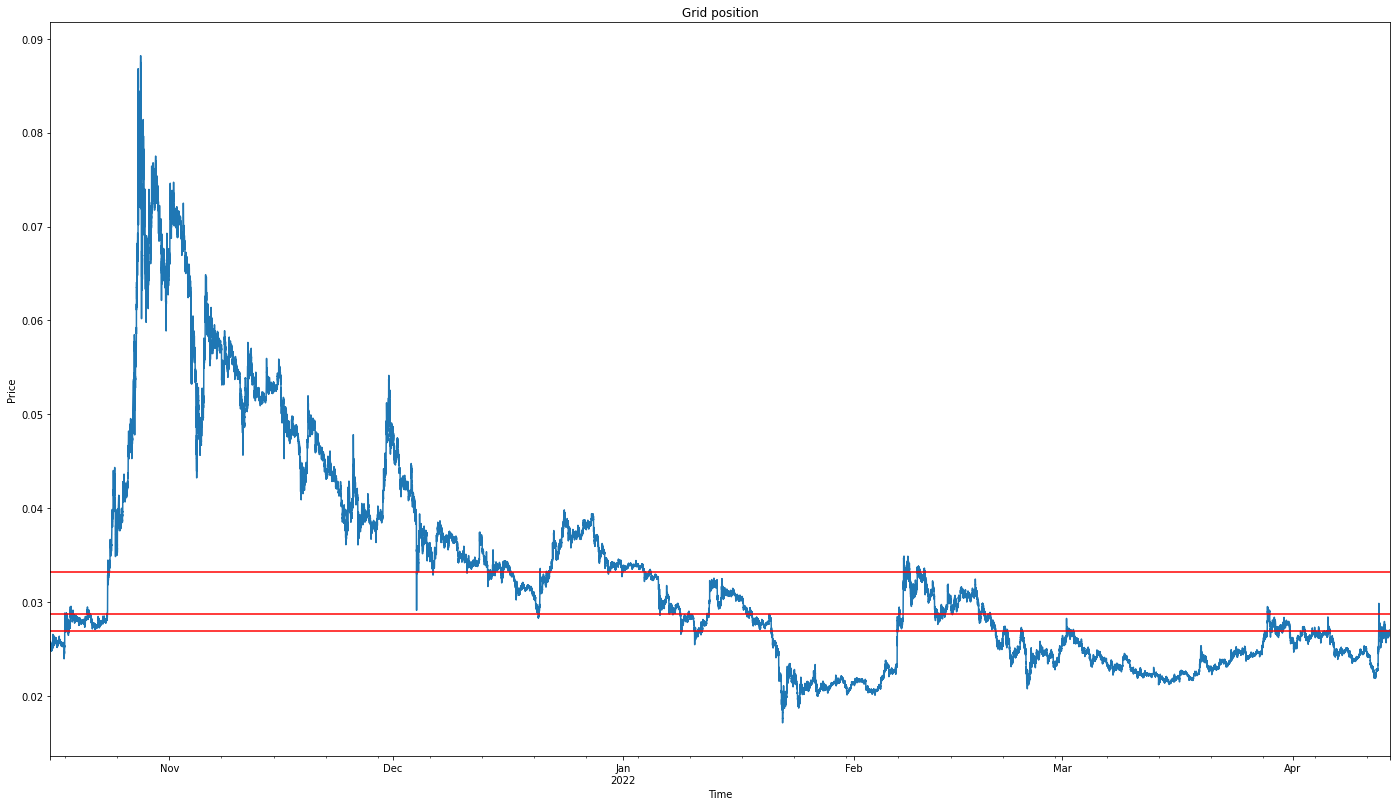

In [110]:
config_to_test['short'] = {"auto_unstuck_ema_dist": 0.09972790931046338,
           "auto_unstuck_wallet_exposure_threshold": 0.06559262162518376,
           "ddown_factor": 2.304489996146624,
           "ema_span_0": 1055.6577441874203,
           "ema_span_1": 2888.7744234017828,
           "enabled": True,
           "initial_eprice_ema_dist": -0.02998678962458838,
           "initial_qty_pct": 0.07702488418844138,
           "markup_range": 0.022206983627948464,
           "min_markup": 0.014231970991650302,
           "n_close_orders": 9,
           "rentry_pprice_dist": 0.025,
           "rentry_pprice_dist_wallet_exposure_weighting": 22.60722411105582,
           "wallet_exposure_limit": 0.1517033532129698}

grid_short = calc_recursive_entries_short(
    Args().starting_balance,
    0.0,
    0.0,
    df.price.iloc[-1],
    df.price.iloc[-1],
    config_to_test["inverse"],
    config_to_test["qty_step"],
    config_to_test["price_step"],
    config_to_test["min_qty"],
    config_to_test["min_cost"],
    config_to_test["c_mult"],
    config_to_test["short"]["initial_qty_pct"],
    config_to_test["short"]["initial_eprice_ema_dist"],
    config_to_test["short"]["ddown_factor"],
    config_to_test["short"]["rentry_pprice_dist"],
    config_to_test["short"]["rentry_pprice_dist_wallet_exposure_weighting"],
    config_to_test["short"]["wallet_exposure_limit"],
    config_to_test["short"]["auto_unstuck_ema_dist"],
    config_to_test["short"]["auto_unstuck_wallet_exposure_threshold"],
    whole_grid=True,
)

gdf_short = pd.DataFrame(
    grid_short, columns=["qty", "price", "type", "psize", "pprice", "wallet_exposure"]
)
gdf_short.loc[:, "eprice_pprice_diff"] = abs(gdf_short.price - gdf_short.pprice) / gdf_short.price
gdf_short.loc[:, "ddown_factor"] = gdf_short.qty / gdf_short.psize.shift()
gdf_short.loc[:, "bkr_price"] = gdf_short.apply(
    lambda x: calc_bankruptcy_price(
        Args().starting_balance,
        x.psize,
        x.pprice,
        0.0,
        0.0,
        config_to_test["inverse"],
        config_to_test["c_mult"],
    ),
    axis=1,
)

# Display grid on graph
n_ticks = 60 * 60 * 24 * 180  # 14 days
dfx = pd.DataFrame(
    {
        "timestamp": pd.to_datetime(timestamps[-n_ticks:], unit="ms"),
        "price": prices[-n_ticks:],
    }
).set_index("timestamp")
lastdayfrom = pd.to_datetime(Args().end_date)
# lastdayfrom = pd.Timestamp('2021-05-21')
fig = (
    dfx.price.loc[lastdayfrom - pd.Timedelta(days=180) : lastdayfrom]
    .iloc[::100]
    .plot(title="Grid position", xlabel="Time", ylabel="Price")
)

for i, e in enumerate(gdf_short.itertuples()):
    fig.axhline(y=e.price, color="r", linestyle="-")
print(f"Grid Span Short = {(gdf_short.price.iloc[-1] / gdf_short.price.iloc[0] - 1) * 100:.2f}%")

pd.concat([gdf_long, gdf_short]).sort_values("price", ascending=False)

In [111]:
sts = time()
fills_long, fills_short, stats = backtest(config_to_test, dataslice)
elapsed = time() - sts
print(f"seconds elapsed {elapsed:.4f}")
longs, shorts, sdf, analysis = analyze_fills(fills_long, fills_short, stats, config_to_test)
pprint.pprint(analysis)

seconds elapsed 5.2580
{'DGstd_long': 0.00212443875437263,
 'DGstd_short': 0.001852593211039267,
 'adg_DGstd_ratio_long': 0.11413719618401148,
 'adg_DGstd_ratio_short': 0.18970026866256737,
 'adg_long': 0.00024247748288874587,
 'adg_per_exposure_long': 0.0014857265132255384,
 'adg_per_exposure_short': 0.002316609504097312,
 'adg_realized_long': 0.0002377125523136403,
 'adg_realized_per_exposure_long': 0.00145653046745348,
 'adg_realized_per_exposure_short': 0.002354845540366938,
 'adg_realized_short': 0.0003572379647722723,
 'adg_short': 0.00035143742985659733,
 'avg_fills_per_day_long': 1.4166666666666667,
 'avg_fills_per_day_short': 12.416666666666666,
 'biggest_psize_long': 43107.0,
 'biggest_psize_quote_long': 1062.009963,
 'biggest_psize_quote_short': 1548.7918229999996,
 'biggest_psize_short': 60799.0,
 'closest_bkr_long': 1.0,
 'closest_bkr_short': 1.0,
 'eqbal_ratio_mean_long': 0.9981362749018993,
 'eqbal_ratio_mean_short': 0.9985735092697609,
 'eqbal_ratio_min_long': 0.9833314

In [77]:
sdf

,timestamp,bkr_price_long,bkr_price_short,psize_long,pprice_long,psize_short,pprice_short,price,closest_bkr_long,closest_bkr_short,balance_long,balance_short,equity_long,equity_short,wallet_exposure_long,wallet_exposure_short
0,1644710399000.0,0.0,0.0000000000,0.0,0.000000,0.0,0.0000000000,0.029140,1.0,1.0,10000.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,0.0000000000,0.0000000000
1,1644710459000.0,0.0,0.0000000000,0.0,0.000000,0.0,0.0000000000,0.029091,1.0,1.0,10000.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,0.0000000000,0.0000000000
2,1644710519000.0,0.0,0.0000000000,0.0,0.000000,0.0,0.0000000000,0.029015,1.0,1.0,10000.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,0.0000000000,0.0000000000
3,1644710579000.0,0.0,0.0000000000,0.0,0.000000,0.0,0.0000000000,0.028957,1.0,1.0,10000.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,0.0000000000,0.0000000000
4,1644710639000.0,0.0,0.0000000000,0.0,0.000000,0.0,0.0000000000,0.028963,1.0,1.0,10000.0000000000,10000.0000000000,10000.0000000000,10000.0000000000,0.0000000000,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86396,1649894159000.0,0.0,0.1911475708,3213.0,0.026457,-62076.0,0.0252483456,0.026802,1.0,1.0,10048.0671480962,10298.3603031928,10049.1756330962,10201.9156551928,0.0084599694,0.1521908593
86397,1649894219000.0,0.0,0.1911475708,3213.0,0.026457,-62076.0,0.0252483456,0.026801,1.0,1.0,10048.0671480962,10298.3603031928,10049.1724200962,10201.9777311928,0.0084599694,0.1521908593
86398,1649894279000.0,0.0,0.1911475708,3213.0,0.026457,-62076.0,0.0252483456,0.026829,1.0,1.0,10048.0671480962,10298.3603031928,10049.2623840962,10200.2396031928,0.0084599694,0.1521908593
86399,1649894339000.0,0.0,0.1911475708,3213.0,0.026457,-62076.0,0.0252483456,0.026948,1.0,1.0,10048.0671480962,10298.3603031928,10049.6447310962,10192.8525591928,0.0084599694,0.1521908593


<AxesSubplot:title={'center':'Balance and equity long'}, xlabel='Time', ylabel='Balance'>

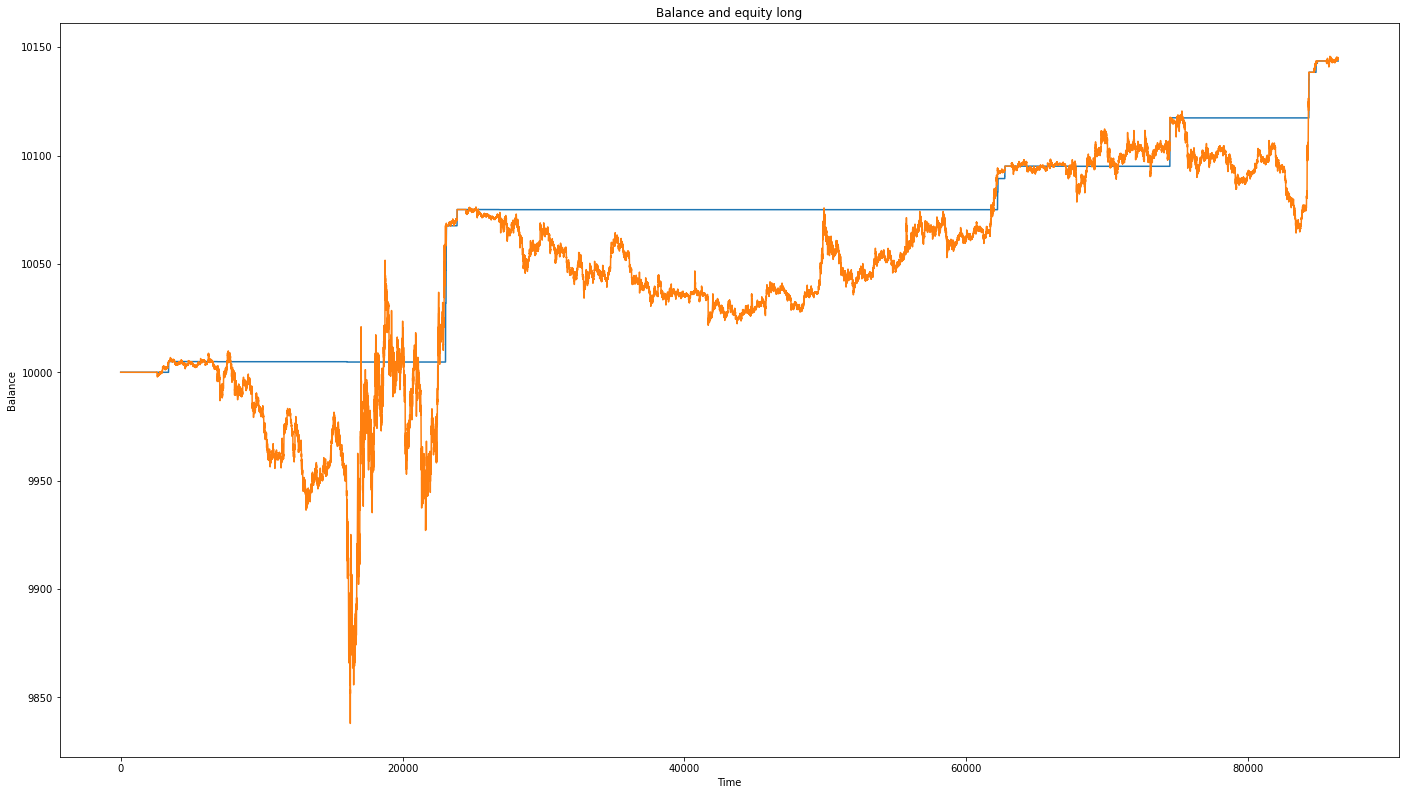

In [112]:
sdf.balance_long.plot()
sdf.equity_long.plot(title="Balance and equity long", xlabel="Time", ylabel="Balance")

<AxesSubplot:title={'center':'Balance and equity short'}, xlabel='Time', ylabel='Balance'>

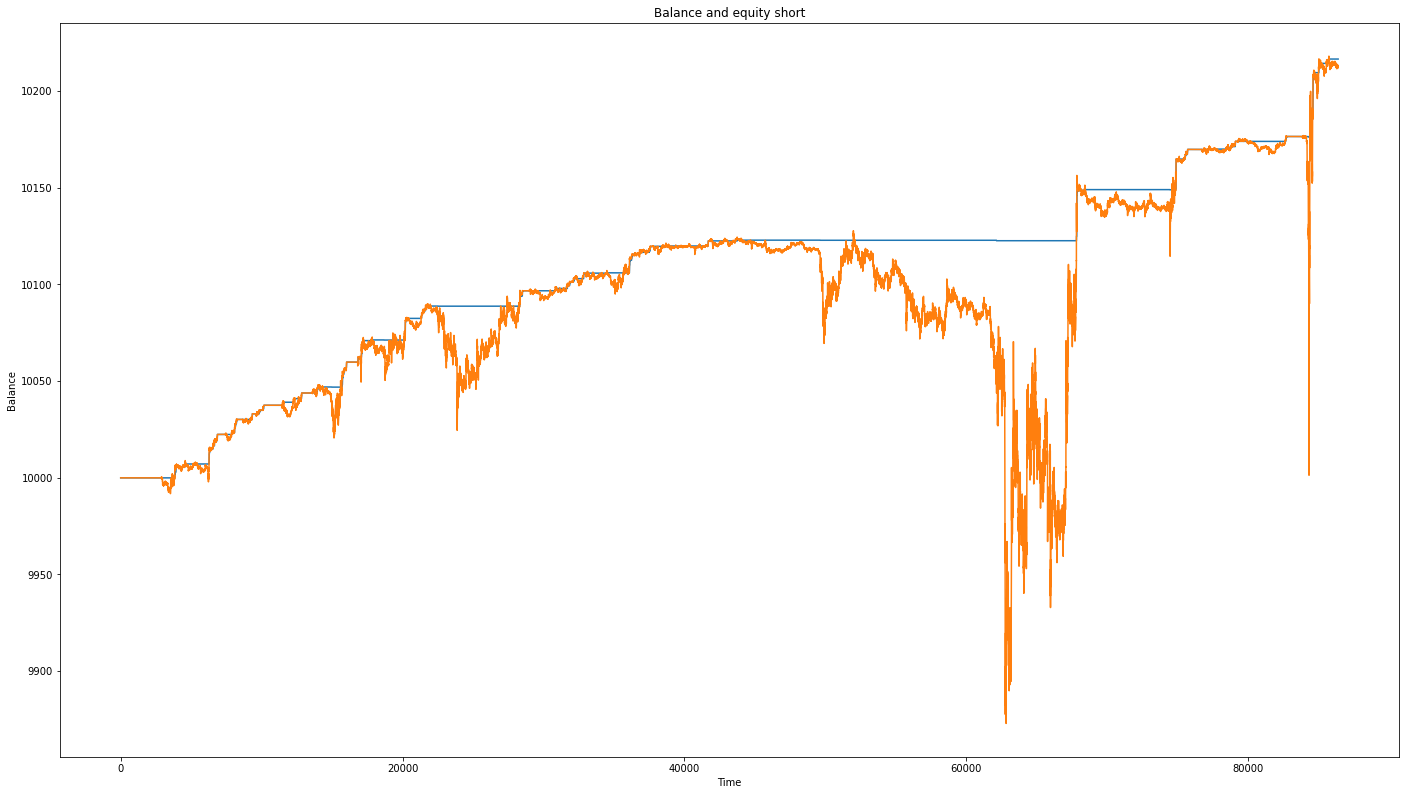

In [113]:
sdf.balance_short.plot()
sdf.equity_short.plot(title="Balance and equity short", xlabel="Time", ylabel="Balance")

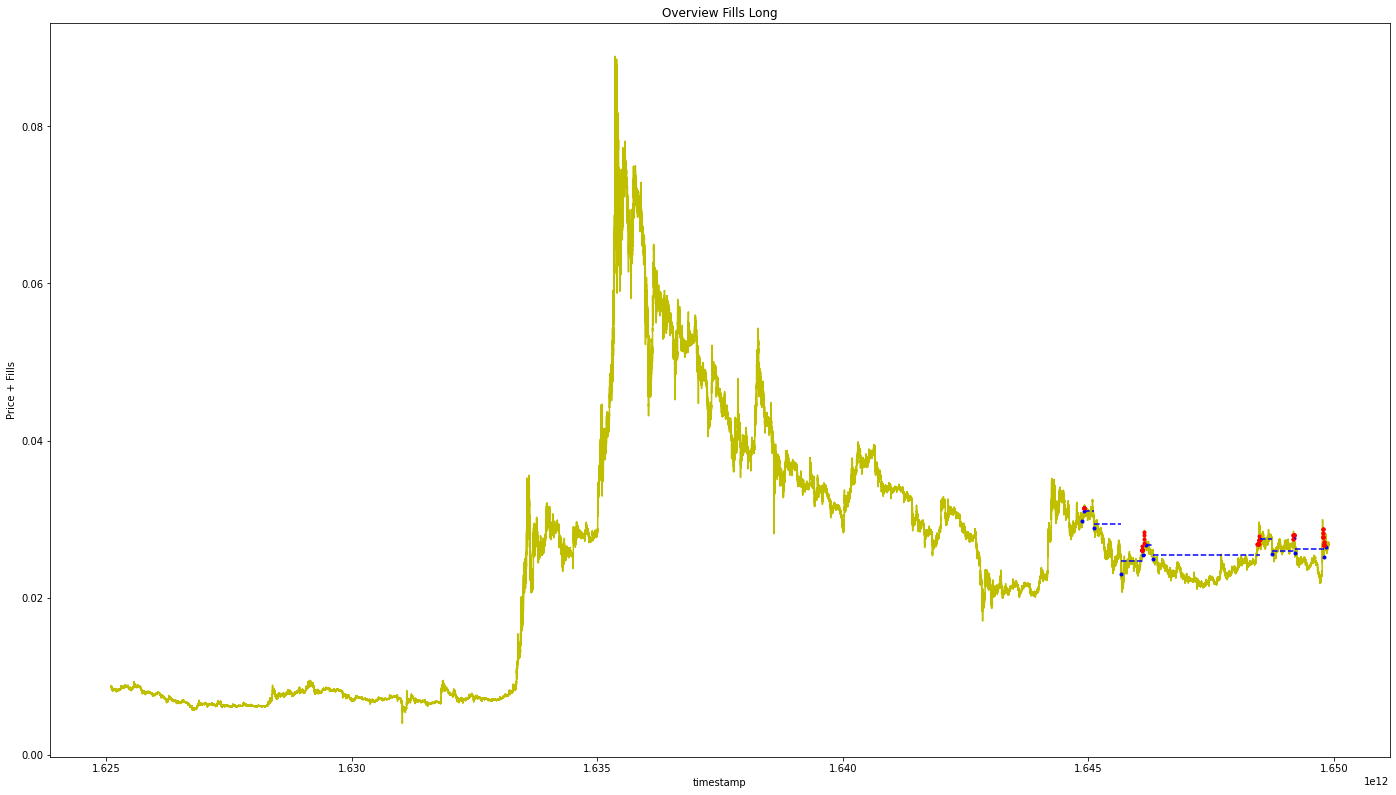

In [114]:
if len(longs) > 0:
    plot_fills(df, longs, plot_whole_df=True, title="Overview Fills Long")

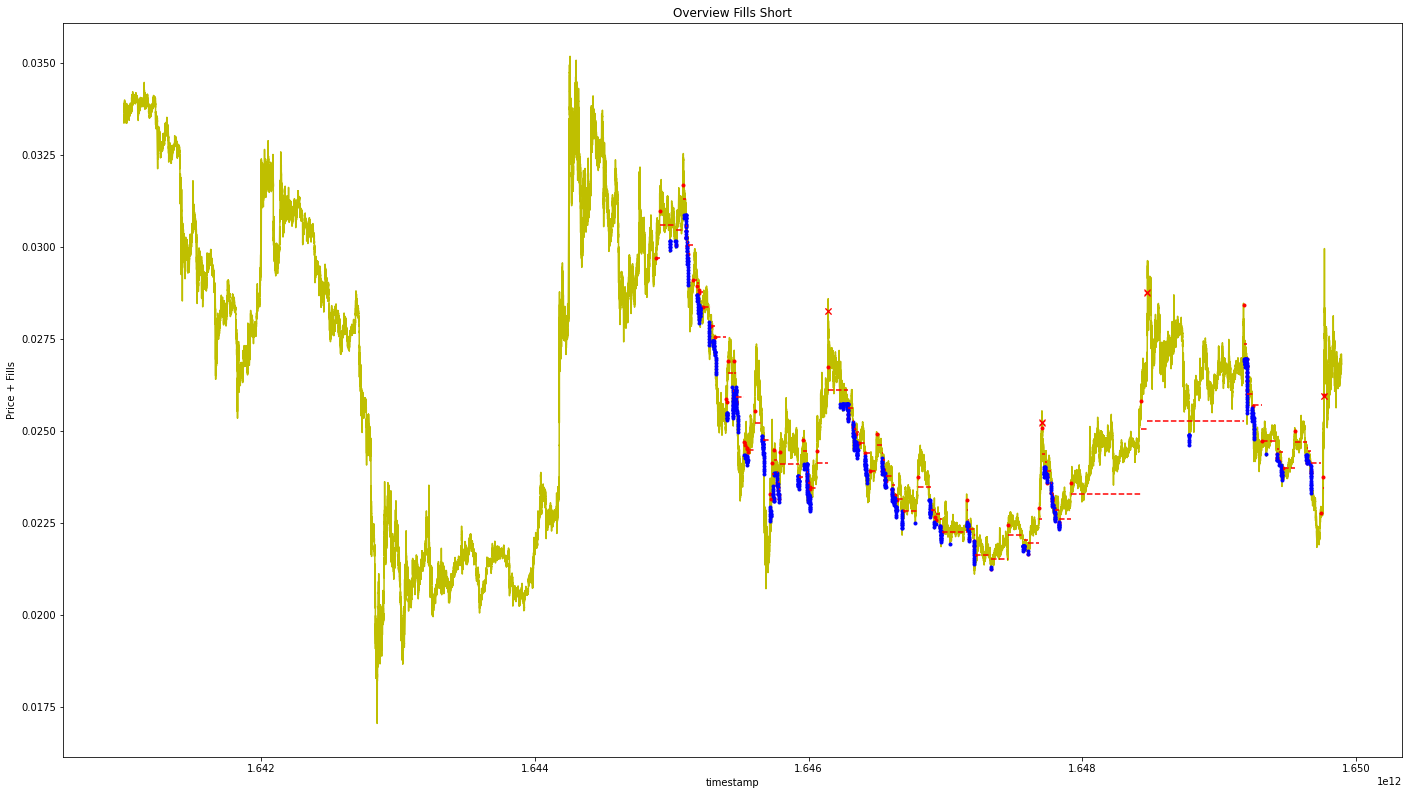

In [81]:
if len(shorts) > 0:
    plot_fills(df, shorts, plot_whole_df=True, title="Overview Fills Short")

<AxesSubplot:title={'center':'Position size in terms of contracts'}, xlabel='Time', ylabel='Long Position size'>

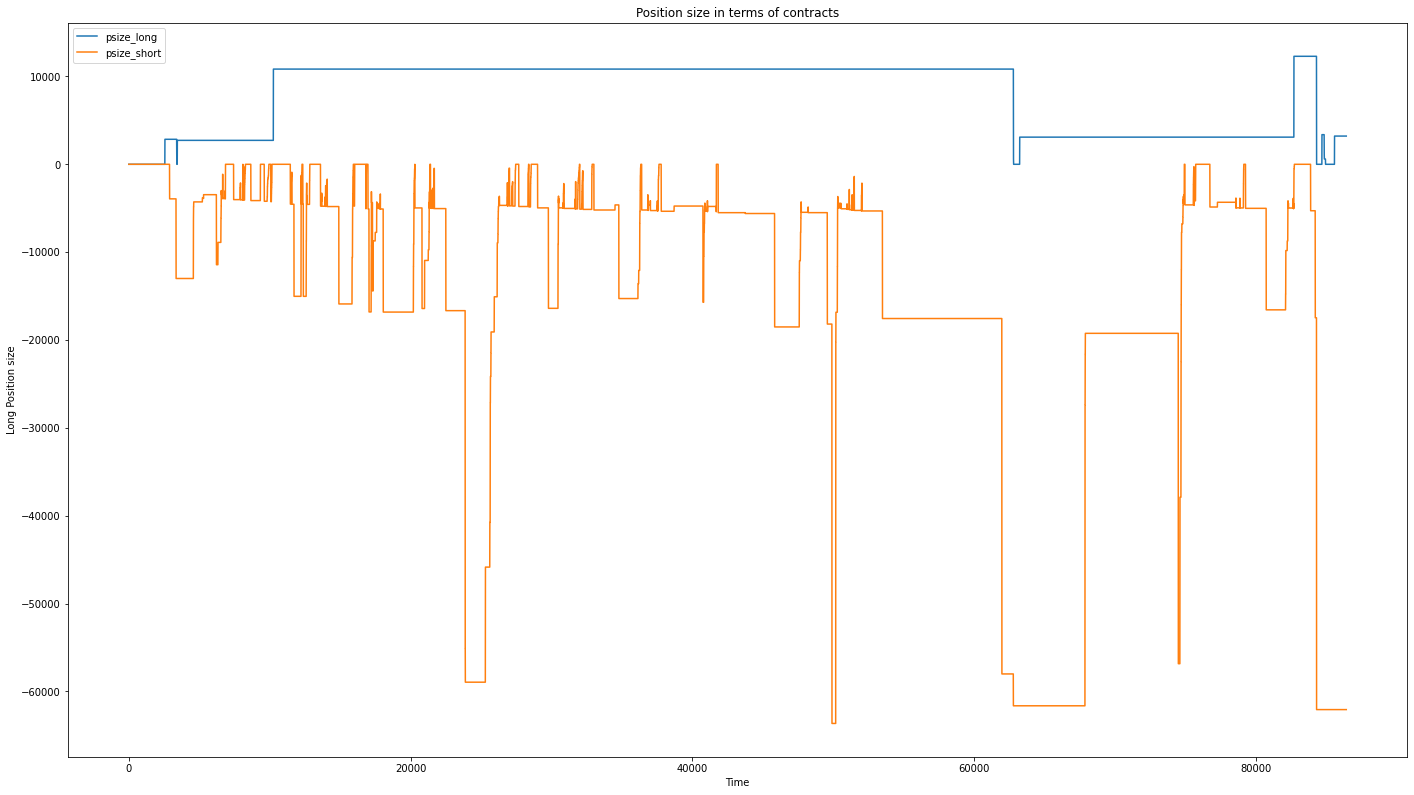

In [82]:
sdf[["psize_long", "psize_short"]].plot(
    title="Position size in terms of contracts", xlabel="Time", ylabel="Long Position size"
)

<AxesSubplot:title={'center':'Average entry price'}, xlabel='Time', ylabel='Price'>

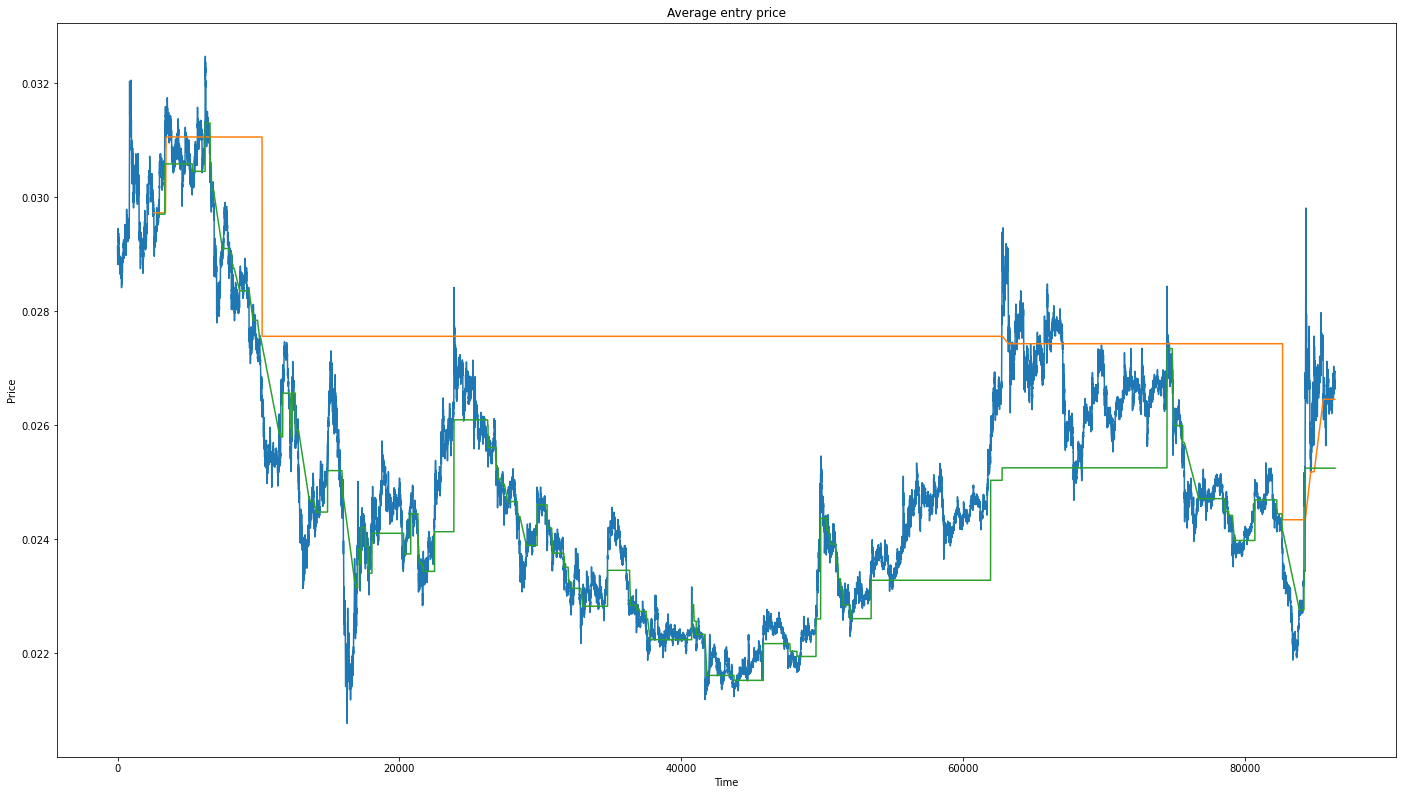

In [83]:
sdf.price.plot(title="Average entry price", xlabel="Time", ylabel="Price")
sdf[sdf.psize_long != 0].pprice_long.replace(0.0, np.nan).plot()
sdf[sdf.psize_short != 0].pprice_short.replace(0.0, np.nan).plot()

Price action distance long mean 0.122564 std 0.077384


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

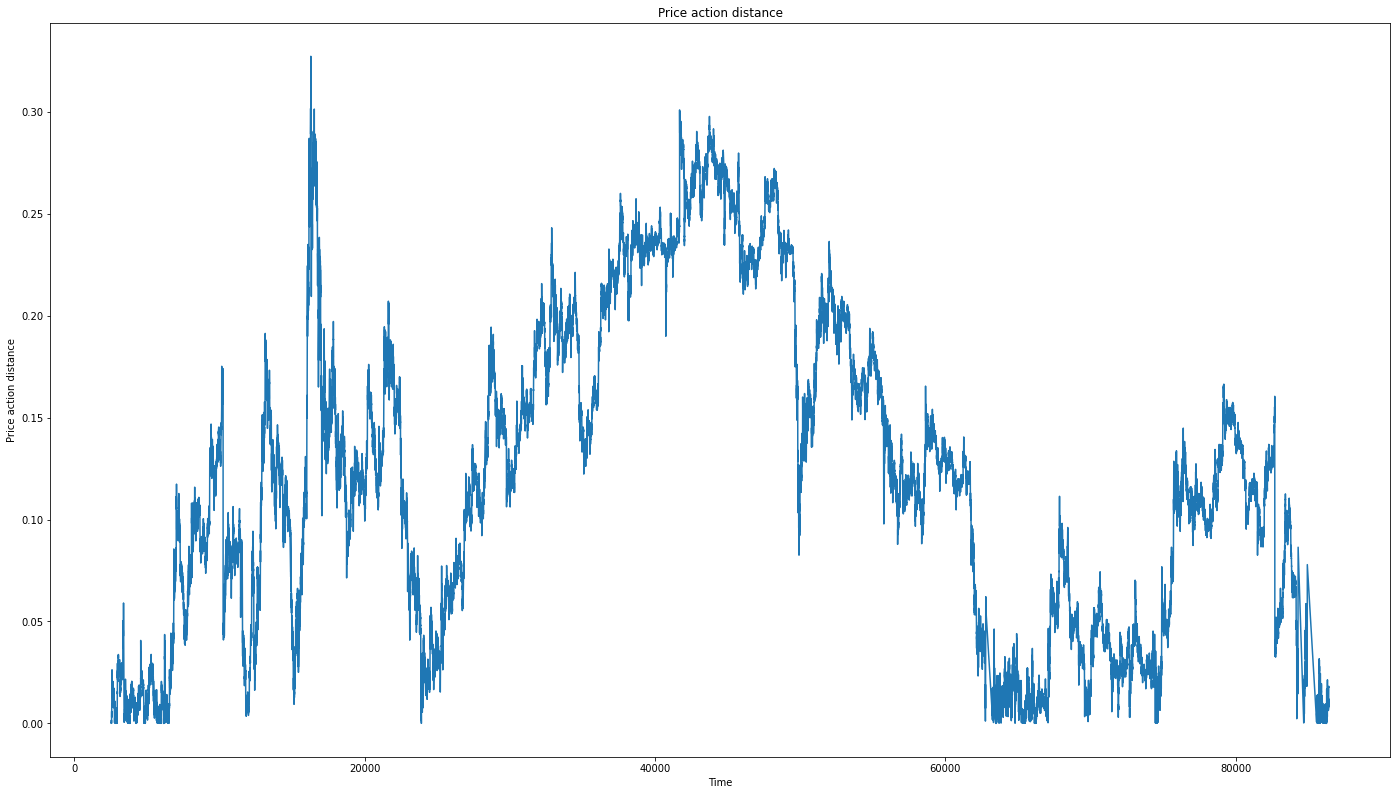

In [84]:
lpprices = sdf[sdf.psize_long != 0.0]
PADistance_long = (lpprices.pprice_long - lpprices.price).abs() / lpprices.price
print(f"Price action distance long mean {PADistance_long.mean():.6f} std {PADistance_long.std():.6f}")
PADistance_long.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

Mean price action distance short 0.024484


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

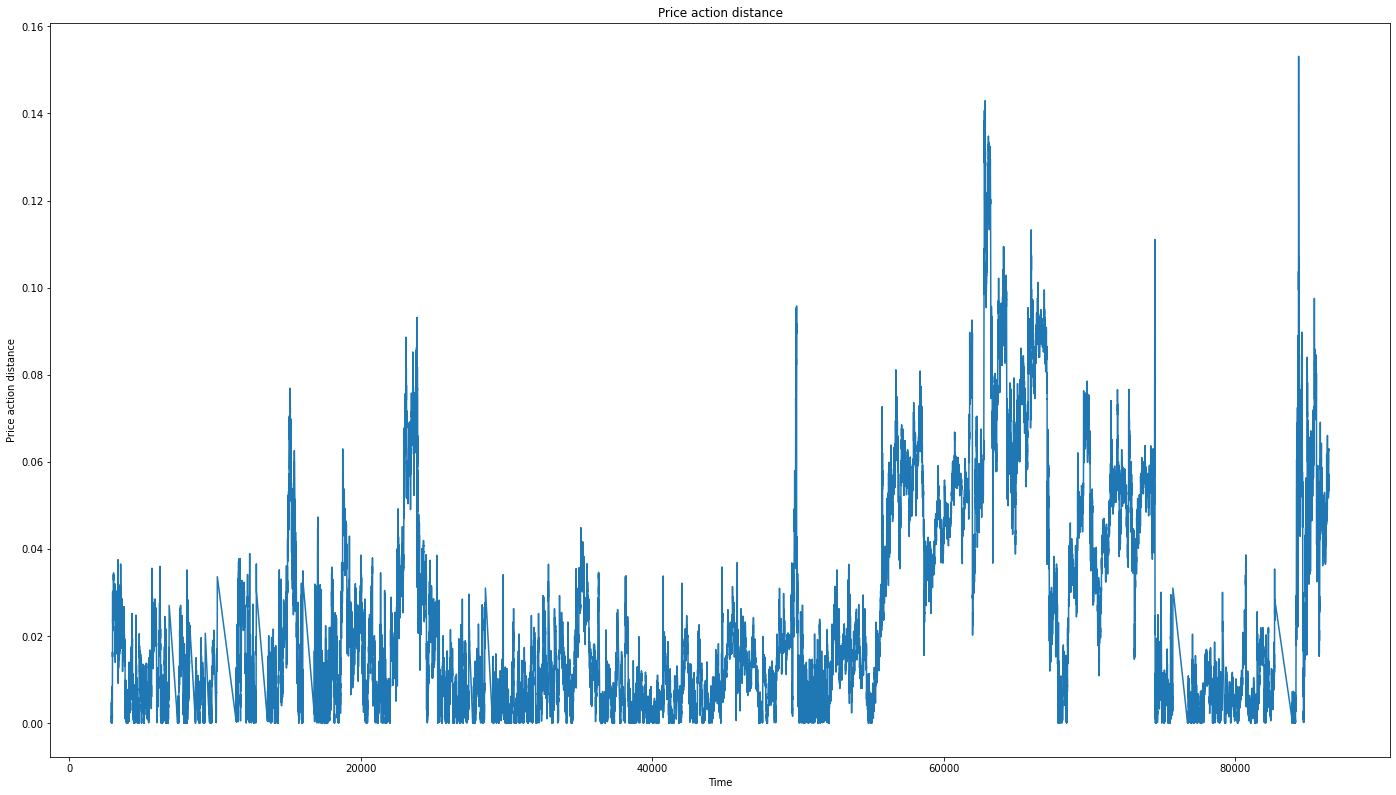

In [85]:
spprices = sdf[sdf.psize_short != 0.0]
PADistance_short = (spprices.pprice_short - spprices.price).abs() / spprices.price
print(f"Mean price action distance short {PADistance_short.mean():.6f}")
PADistance_short.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

spans in minutes [1590.7673738930807, 2016.263215658276, 2555.569985614937] n_days 103.0


<AxesSubplot:title={'center':'Unstucking Bands and Initial Entry Band'}, xlabel='timestamp'>

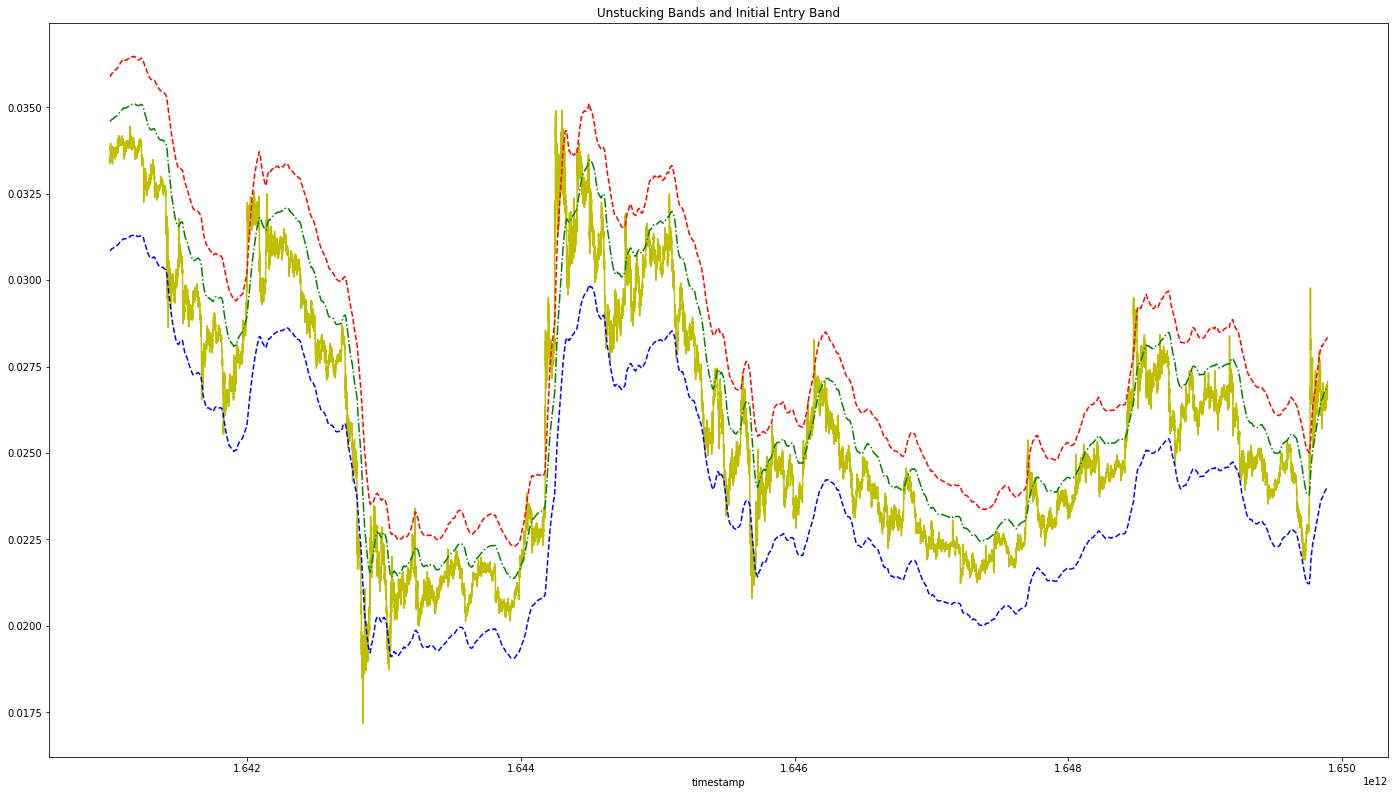

In [86]:
# Inspect long EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["long"]["ema_span_0"],
    (config_to_test["long"]["ema_span_0"] * config_to_test["long"]["ema_span_1"]) ** 0.5,
    config_to_test["long"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)

spans_multiplier = 60 / ((timestamps[1] - timestamps[0]) / 1000)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * spans_multiplier)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["long"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["long"]["auto_unstuck_ema_dist"])
long_ientry_band = ema_band_lower * (1 - config_to_test["long"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(
    style="b--",
)
unstucking_band_upper.iloc[::100].plot(style="r--")
long_ientry_band.iloc[::100].plot(style="g-.")

spans in minutes [1055.6577441874203, 1746.298110654261, 2888.7744234017828] n_days 103.0


<AxesSubplot:title={'center':'Unstucking Bands and Initial Entry Band'}, xlabel='timestamp'>

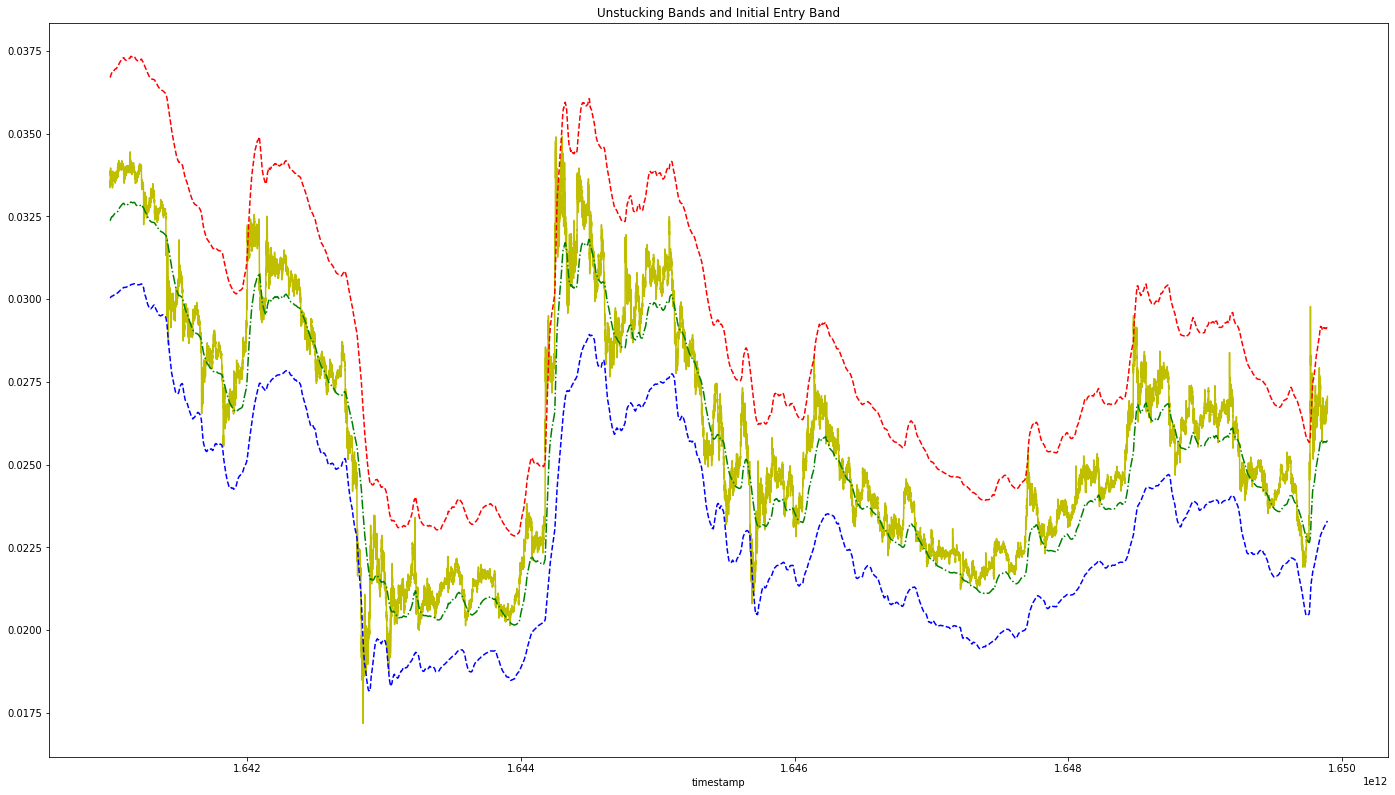

In [87]:
# Inspect short EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["short"]["ema_span_0"],
    (config_to_test["short"]["ema_span_0"] * config_to_test["short"]["ema_span_1"]) ** 0.5,
    config_to_test["short"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)

spans_multiplier = 60 / ((timestamps[1] - timestamps[0]) / 1000)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * spans_multiplier)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["short"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["short"]["auto_unstuck_ema_dist"])
short_ientry_band = ema_band_upper * (1 + config_to_test["short"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(style="b--")
unstucking_band_upper.iloc[::100].plot(style="r--")
short_ientry_band.iloc[::100].plot(style="g-.")